In [354]:
import os
import cv2
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import keras
from keras.layers import Input
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Phase 1: Dataset Preparation

In [361]:
dataset_path = '/Users/maheshnilewar/Documents/CV_Assignment/TinyImageNet100'
output_path = '/Users/maheshnilewar/Documents/CV_Assignment'

def prepare_dataset(dataset_path, output_path, num_classes=15):
    os.makedirs(output_path, exist_ok=True)
    
    # Getting all class folders and selected classes
    class_folders = sorted(os.listdir(dataset_path))
    selected_classes = random.sample(class_folders, num_classes)
    
    # Keep selected classes labeled the same.
    with open(os.path.join(output_path, "class_labels.txt"), "w") as f:
        for i, cls in enumerate(selected_classes):
            f.write(f"{cls},{i}\n")
    
    for cls in selected_classes:
        # Collect all images for the class.
        class_images_path = os.path.join(dataset_path, cls, "images")
        images = sorted(os.listdir(class_images_path))

        if not os.path.isdir(class_images_path):  # Skip if not a directory
            print(f"Skipping: {class_images_path} (Not a directory)")
            continue

        # Separating training and testing images
        training_images = images[:400]
        testing_images = images[400:500]

        # Save training images
        train_dir = os.path.join(output_path, "train", cls)
        os.makedirs(train_dir, exist_ok=True)
        for img in training_images:
            os.link(os.path.join(class_images_path, img), os.path.join(train_dir, img))

        # Save testing images
        test_dir = os.path.join(output_path, "test", cls)
        os.makedirs(test_dir, exist_ok=True)
        for img in testing_images:
            os.link(os.path.join(class_images_path, img), os.path.join(test_dir, img))

    print(f"Dataset with {num_classes} classes prepared at: {output_path}")

prepare_dataset(dataset_path, output_path, num_classes=15)

def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    # Read class label mappings.
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
    
    return images, np.array(labels)

# Load train and test images
train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

train_images, train_labels = load_images(train_path, class_labels_file)
test_images, test_labels = load_images(test_path, class_labels_file)

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images.")

Dataset with 15 classes prepared at: /Users/maheshnilewar/Documents/CV_Assignment
Loaded 6000 training images and 1500 test images.


# Phase 2: Conduct image classification using the hand-crafted feature approach

Bag of Words (BoW) model using ORB (Oriented FAST and rotated BRIEF) features

SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.31      0.04      0.07       100
           2       0.11      0.06      0.08       100
           3       0.08      0.89      0.14       100
           4       0.00      0.00      0.00       100
           5       0.07      0.02      0.03       100
           6       0.03      0.01      0.01       100
           7       0.08      0.01      0.02       100
           8       0.04      0.01      0.02       100
           9       0.00      0.00      0.00       100
          10       0.10      0.01      0.02       100
          11       0.03      0.01      0.01       100
          12       0.09      0.03      0.05       100
          13       0.11      0.04      0.06       100
          14       0.11      0.02      0.03       100

    accuracy                           0.08      1500
   macro avg       0.08      0.08      0.04      150

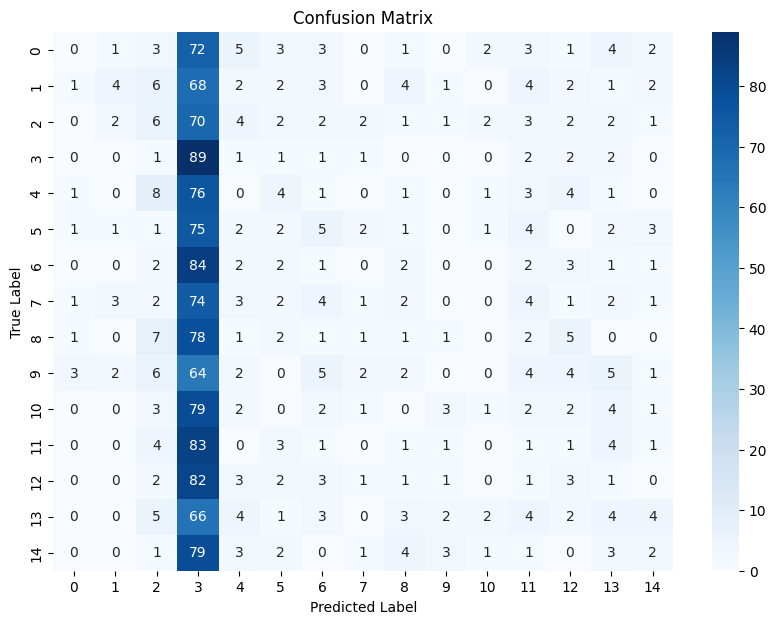

In [363]:
def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
                        image_paths.append(img_path)
    
    return images, np.array(labels), image_paths

def extract_features(image_paths, method='ORB'):
    descriptor_list = []
    
    if method == 'ORB':
        detector = cv2.ORB_create(nfeatures=500) 
    else:
        raise ValueError("Invalid method! Choose 'ORB'")
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = detector.detectAndCompute(img, None)
        if descriptors is not None:
            descriptor_list.append(descriptors)
    
    return descriptor_list

def create_bow_dictionary(descriptor_list, num_clusters=100):
    all_descriptors = np.vstack(descriptor_list)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    return kmeans

def create_feature_vectors(image_paths, kmeans, num_clusters=100):
    feature_vectors = []
    
    detector = cv2.ORB_create(nfeatures=500)  # ORB with 500 keypoints
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = detector.detectAndCompute(img, None)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            hist, _ = np.histogram(labels, bins=np.arange(num_clusters+1))
            feature_vectors.append(hist)
        else:
            feature_vectors.append(np.zeros(num_clusters))
    
    return np.array(feature_vectors)


train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

# Load Images
train_images, train_labels, train_image_paths = load_images(train_path, class_labels_file)
test_images, test_labels, test_image_paths = load_images(test_path, class_labels_file)

# Extract Features using ORB
descriptor_list = extract_features(train_image_paths, method='ORB')

# Create BoW Dictionary
kmeans = create_bow_dictionary(descriptor_list)

# Create Feature Vectors
X_train = create_feature_vectors(train_image_paths, kmeans)
X_test = create_feature_vectors(test_image_paths, kmeans)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training SVM Classifier
svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm.fit(X_train, train_labels)
predictions = svm.predict(X_test)

print("SVM Classifier Performance:")
print(classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(test_labels))), yticklabels=range(len(set(test_labels))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Bag of Words (BoW) model using SIFT (Scale-Invariant Feature Transform) features

SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.19      0.18      0.18       100
           1       0.17      0.16      0.16       100
           2       0.26      0.20      0.23       100
           3       0.34      0.43      0.38       100
           4       0.28      0.43      0.34       100
           5       0.13      0.09      0.11       100
           6       0.17      0.14      0.15       100
           7       0.24      0.23      0.24       100
           8       0.09      0.05      0.06       100
           9       0.21      0.38      0.27       100
          10       0.12      0.12      0.12       100
          11       0.33      0.45      0.38       100
          12       0.35      0.26      0.30       100
          13       0.09      0.06      0.07       100
          14       0.22      0.20      0.21       100

    accuracy                           0.23      1500
   macro avg       0.21      0.23      0.21      150

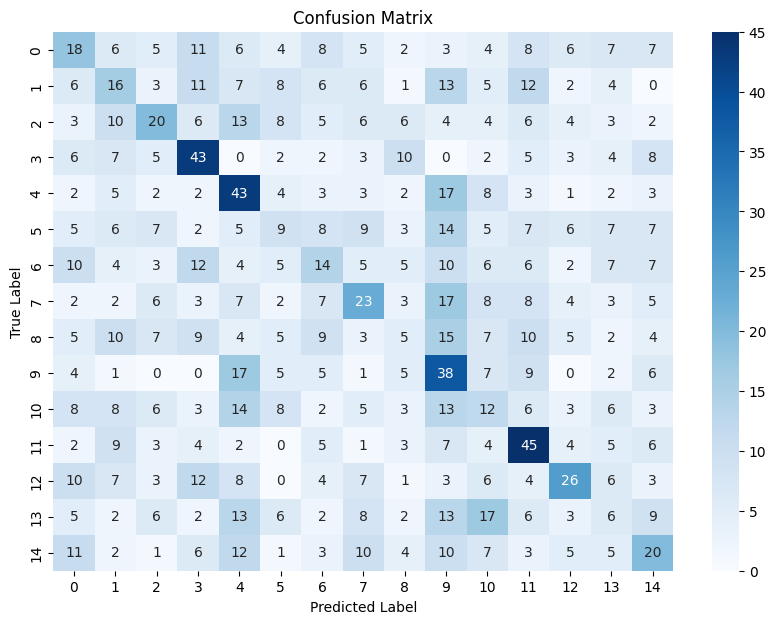

In [365]:
def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
                        image_paths.append(img_path)
    
    return images, np.array(labels), image_paths

def extract_features(image_paths, method='SIFT'):
    descriptor_list = []
    
    if method == 'SIFT':
        detector = cv2.SIFT_create()
    else:
        raise ValueError("Invalid method! Choose 'SIFT'")
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = detector.detectAndCompute(img, None)
        if descriptors is not None:
            descriptor_list.append(descriptors)
    
    return descriptor_list

def create_bow_dictionary(descriptor_list, num_clusters=100):
    all_descriptors = np.vstack(descriptor_list)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

def create_feature_vectors(image_paths, kmeans, num_clusters=100):
    feature_vectors = []
    
    detector = cv2.SIFT_create()
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = detector.detectAndCompute(img, None)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            hist, _ = np.histogram(labels, bins=np.arange(num_clusters+1))
            feature_vectors.append(hist)
        else:
            feature_vectors.append(np.zeros(num_clusters))
    
    return np.array(feature_vectors)

train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

train_images, train_labels, train_image_paths = load_images(train_path, class_labels_file)
test_images, test_labels, test_image_paths = load_images(test_path, class_labels_file)

descriptor_list = extract_features(train_image_paths)
kmeans = create_bow_dictionary(descriptor_list, num_clusters=100)

X_train = create_feature_vectors(train_image_paths, kmeans)
X_test = create_feature_vectors(test_image_paths, kmeans)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma=0.01))
svm.fit(X_train, train_labels)
predictions = svm.predict(X_test)

print("SVM Classifier Performance:")
print(classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))

conf_matrix = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(test_labels))), yticklabels=range(len(set(test_labels))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Image classification using the Fisher Vector representation of ORB descriptors

SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.05      0.01      0.02       100
           1       0.03      0.01      0.02       100
           2       0.19      0.04      0.07       100
           3       0.08      0.89      0.14       100
           4       0.02      0.01      0.01       100
           5       0.10      0.03      0.05       100
           6       0.04      0.01      0.02       100
           7       0.00      0.00      0.00       100
           8       0.06      0.01      0.02       100
           9       0.17      0.07      0.10       100
          10       0.04      0.01      0.02       100
          11       0.04      0.01      0.02       100
          12       0.08      0.02      0.03       100
          13       0.11      0.02      0.03       100
          14       0.00      0.00      0.00       100

    accuracy                           0.08      1500
   macro avg       0.07      0.08      0.04      150

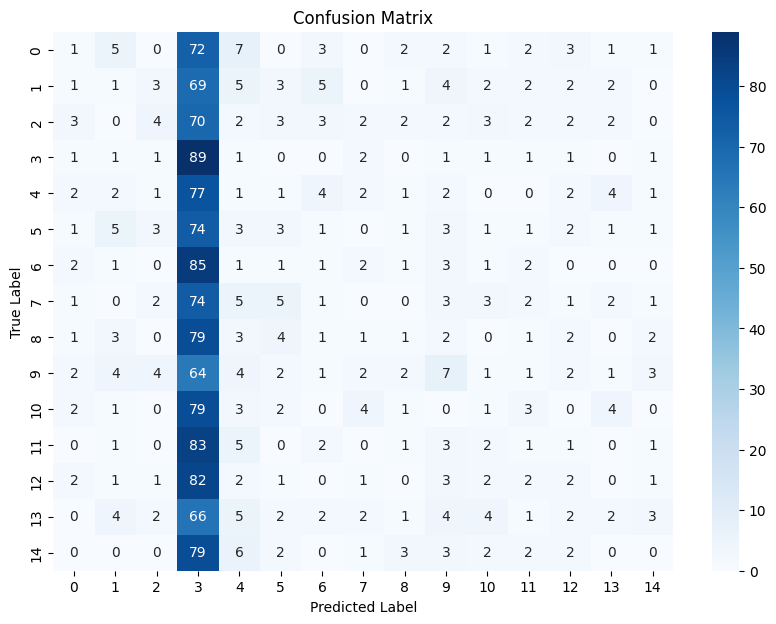

In [367]:
def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
                        image_paths.append(img_path)
    
    return images, np.array(labels), image_paths

# Extract ORB Features (instead of SIFT)
def extract_orb_features(image_paths):
    orb = cv2.ORB_create(nfeatures=500)  
    descriptor_list = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            descriptor_list.append(descriptors)

    return descriptor_list

# Train Gaussian Mixture Model (GMM)
def train_gmm(descriptor_list, num_clusters=64):
    if len(descriptor_list) == 0:
        raise ValueError("No ORB descriptors found. Cannot train GMM.")

    all_descriptors = np.vstack(descriptor_list)  # Stack all descriptors
    scaler = StandardScaler()
    all_descriptors = scaler.fit_transform(all_descriptors)  # Normalize features
    
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='diag', random_state=42, max_iter=500, init_params='random_from_data')
    gmm.fit(all_descriptors)
    
    return gmm

# Compute Fisher Vector Encoding using ORB Descriptors
def fisher_vector_encoding(image_paths, gmm, num_clusters=64):
    orb = cv2.ORB_create(nfeatures=500)  # Adjust the number of features as needed
    feature_vectors = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            # Compute Fisher Vector Encoding
            probs = gmm.predict_proba(descriptors)
            means = (probs.T @ descriptors - gmm.means_) / np.sqrt(gmm.covariances_)
            covs = (probs.T @ (descriptors ** 2) - gmm.means_ ** 2 - gmm.covariances_) / np.sqrt(2 * gmm.covariances_)

            fisher_vector = np.hstack((means.flatten(), covs.flatten()))
            feature_vectors.append(fisher_vector)
        else:
            feature_vectors.append(np.zeros(num_clusters * 2 * 32))  

    return np.array(feature_vectors)

# Prepare Dataset Paths
output_path = "/Users/maheshnilewar/Documents/CV_Assignment"  
train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

# Load Images and Labels
train_images, train_labels, train_image_paths = load_images(train_path, class_labels_file)
test_images, test_labels, test_image_paths = load_images(test_path, class_labels_file)

# Extract ORB Descriptors
descriptor_list = extract_orb_features(train_image_paths)

# Train GMM 
num_clusters = 64  
gmm = train_gmm(descriptor_list, num_clusters=num_clusters)

# Compute Fisher Vector Encodings
X_train = fisher_vector_encoding(train_image_paths, gmm, num_clusters)
X_test = fisher_vector_encoding(test_image_paths, gmm, num_clusters)

# Standardization 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier
svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm.fit(X_train, train_labels)
predictions = svm.predict(X_test)

# Print Performance
print("SVM Classifier Performance:")
print(classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(test_labels))), yticklabels=range(len(set(test_labels))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Image classification using the Fisher Vector representation of SIFT descriptors

SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.17      0.19      0.18       100
           1       0.22      0.22      0.22       100
           2       0.20      0.24      0.22       100
           3       0.49      0.50      0.50       100
           4       0.25      0.38      0.30       100
           5       0.18      0.17      0.17       100
           6       0.11      0.09      0.10       100
           7       0.17      0.20      0.19       100
           8       0.17      0.17      0.17       100
           9       0.23      0.33      0.27       100
          10       0.17      0.14      0.16       100
          11       0.44      0.41      0.42       100
          12       0.25      0.16      0.19       100
          13       0.14      0.10      0.12       100
          14       0.26      0.18      0.21       100

    accuracy                           0.23      1500
   macro avg       0.23      0.23      0.23      150

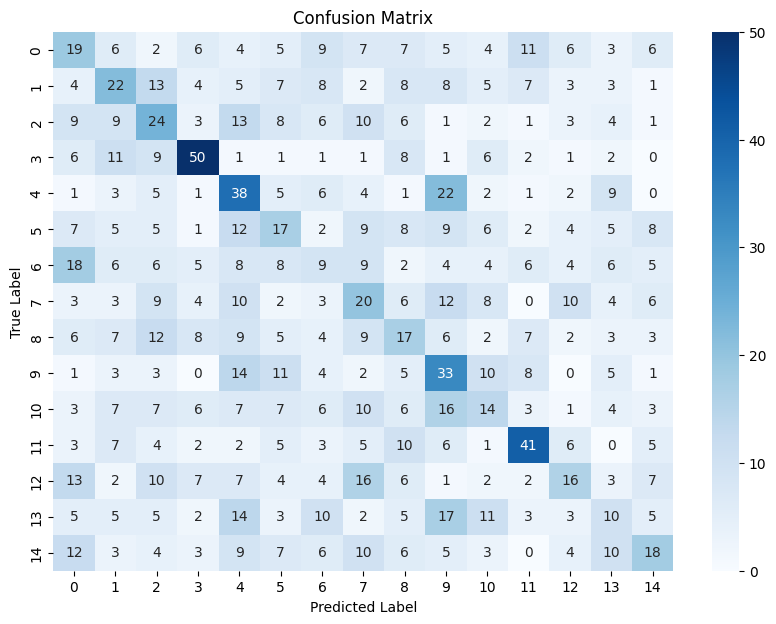

In [369]:
def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
                        image_paths.append(img_path)
    
    return images, np.array(labels), image_paths

# Extract SIFT Features
def extract_sift_features(image_paths):
    sift = cv2.SIFT_create()
    descriptor_list = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptor_list.append(descriptors)

    return descriptor_list

# Train Gaussian Mixture Model
def train_gmm(descriptor_list, num_clusters=64):
    if len(descriptor_list) == 0:
        raise ValueError("No SIFT descriptors found. Cannot train GMM.")

    all_descriptors = np.vstack(descriptor_list)  # Stack all descriptors
    scaler = StandardScaler()
    all_descriptors = scaler.fit_transform(all_descriptors)  # Normalize features
    
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='diag', random_state=42, max_iter=500, init_params='random_from_data')
    gmm.fit(all_descriptors)
    
    return gmm

# Compute Fisher Vector Encoding
def fisher_vector_encoding(image_paths, gmm, num_clusters=64):
    sift = cv2.SIFT_create()
    feature_vectors = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            # Compute Fisher Vector Encoding
            probs = gmm.predict_proba(descriptors)
            means = (probs.T @ descriptors - gmm.means_) / np.sqrt(gmm.covariances_)
            covs = (probs.T @ (descriptors ** 2) - gmm.means_ ** 2 - gmm.covariances_) / np.sqrt(2 * gmm.covariances_)

            fisher_vector = np.hstack((means.flatten(), covs.flatten()))
            feature_vectors.append(fisher_vector)
        else:
            feature_vectors.append(np.zeros(num_clusters * 2 * 128))  # Placeholder for empty feature sets

    return np.array(feature_vectors)

# Prepare Dataset Paths
output_path = "/Users/maheshnilewar/Documents/CV_Assignment"
train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")


train_images, train_labels, train_image_paths = load_images(train_path, class_labels_file)
test_images, test_labels, test_image_paths = load_images(test_path, class_labels_file)

# Extract SIFT Descriptors
descriptor_list = extract_sift_features(train_image_paths)

# Train GMM 
num_clusters = 64  # Number of Gaussian components (experiment with different values)
gmm = train_gmm(descriptor_list, num_clusters=num_clusters)

# Compute Fisher Vector Encodings
X_train = fisher_vector_encoding(train_image_paths, gmm, num_clusters)
X_test = fisher_vector_encoding(test_image_paths, gmm, num_clusters)

# Standardization 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier
svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm.fit(X_train, train_labels)
predictions = svm.predict(X_test)


print("SVM Classifier Performance:")
print(classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(test_labels))), yticklabels=range(len(set(test_labels))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [371]:
def preprocess_images(images, target_size=(64, 64)):
    processed_images = []
    for img in images:
        # Resize image to target size
        img_resized = cv2.resize(img, target_size)
        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0
        processed_images.append(img_normalized)
    return np.array(processed_images)

def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    # Read class label mappings
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
    
    return images, np.array(labels)

# Load train and test images
train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

train_images, train_labels = load_images(train_path, class_labels_file)
test_images, test_labels = load_images(test_path, class_labels_file)

# Preprocess train and test images
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Flatten the images for FCNN
train_images = train_images.reshape((-1, 64 * 64)) 
test_images = test_images.reshape((-1, 64 * 64))  

# One-hot encode the labels for categorical classification
train_labels = to_categorical(train_labels, num_classes=15)
test_labels = to_categorical(test_labels, num_classes=15)

# : Build Fully Connected Neural Network (FCNN)
def create_fcnn_model(input_shape=(64 * 64,), num_classes=15):
    model = Sequential()
    
    # Input layer with the first hidden layer
    model.add(Dense(512, input_dim=input_shape[0], activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    
    # Additional hidden layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create and summarize the FCNN model
model = create_fcnn_model()
model.summary()

#  Train the Model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels),
                    epochs=50, batch_size=32)

# Save the trained model
torch.save(model.state_dict(),'nn_model.pth')

#  Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,823 (8.64 MB)

 Trainable params: 2,263,823 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0622 - loss: 3.1700 - val_accuracy: 0.0667 - val_loss: 2.7065
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0637 - loss: 2.7100 - val_accuracy: 0.0707 - val_loss: 2.7080
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0636 - loss: 2.7088 - val_accuracy: 0.0673 - val_loss: 2.7081
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0575 - loss: 2.7090 - val_accuracy: 0.0667 - val_loss: 2.7080
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0593 - loss: 2.7082 - val_accuracy: 0.0667 - val_loss: 2.7081
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0660 - loss: 2.7082 - val_accuracy: 0.0667 - val_loss: 2.7080
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0655 - loss: 2.7088 - val_accuracy: 0.0667 - val_loss: 2.7081
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0633 - loss: 2.7082 - val_accuracy: 0.

AttributeError: 'Sequential' object has no attribute 'state_dict'